# EDA Exploration Notebook

Exploratory analysis and experimentation. Production logic is in `src/eda.py`.

## Setup

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 300

INCLUDE_SOFT_CHURN = False

current_dir = Path().resolve()
if (current_dir / "churn.duckdb").exists():
    PROJECT_ROOT = current_dir
elif (current_dir.parent / "churn.duckdb").exists():
    PROJECT_ROOT = current_dir.parent
else:
    PROJECT_ROOT = current_dir.parent

DB_PATH = PROJECT_ROOT / "churn.duckdb"
print(f"Database: {DB_PATH}")

Database: W:\CodeBase\Resume-Projects\churn-retention-analytics\churn.duckdb


## Load Data

In [2]:
conn = duckdb.connect(DB_PATH.as_posix())
df_full = conn.execute("SELECT * FROM analytics.churn_features").df()
conn.close()

print(f"Shape: {df_full.shape[0]:,} rows × {df_full.shape[1]} columns")

df_full['lifecycle_stage'] = df_full['recency_days'].apply(
    lambda x: 'Active' if x <= 30 else ('At Risk (31-45d)' if x <= 45 else 'Churned')
)

df_lifecycle = df_full.copy()

if not INCLUDE_SOFT_CHURN:
    df = df_full[df_full['churn_label'].notna()].copy()
    print(f"Filtered to labeled customers only")
else:
    df = df_full.copy()

df_labeled = df.copy()

churned = df['churn_label'] == 1
active = df['churn_label'] == 0
churn_rate = churned.sum() / (churned.sum() + active.sum()) * 100 if (churned.sum() + active.sum()) > 0 else 0
print(f"Churn rate: {churn_rate:.2f}% ({churned.sum():,} churned / {active.sum():,} active)")

df['churn_status'] = df['churn_label'].map({1: 'Churned', 0: 'Active'})
df_full.head()

Shape: 100,000 rows × 18 columns
Filtered to labeled customers only
Churn rate: 7.58% (7,020 churned / 85,590 active)


,customer_id,signup_date,plan,region,last_active_date,active_days,avg_sessions,avg_usage_minutes,avg_usage_last_30d,avg_usage_prev_30d,usage_trend_30d,total_payment_issues,failed_payments_30d,zero_paid_anomalies,total_tickets,high_priority_tickets,recency_days,churn_label,lifecycle_stage
0,1,2024-01-28,Basic,NA,2024-12-16,49,7.061224,57.714286,67.000000,60.0,7.000000,5.0,0.0,0.0,1,0.0,15,0,Active
1,4,2024-05-28,Basic,EU,2024-12-25,37,7.702703,56.486486,48.666667,56.0,-7.333333,5.0,0.0,0.0,2,0.0,6,0,Active
2,6,2023-10-02,Basic,NA,2024-12-19,63,8.444444,64.238095,60.000000,74.0,-14.000000,10.0,0.0,0.0,6,1.0,12,0,Active
3,7,2023-08-10,Pro,EU,2024-12-23,101,25.366337,176.178218,173.666667,125.0,48.666667,6.0,0.0,0.0,7,1.0,8,0,Active
4,12,2024-12-14,Pro,NA,2024-12-29,6,23.333333,203.333333,203.333333,NaN,NaN,0.0,0.0,0.0,1,0.0,2,0,Active


## Lifecycle Distribution

In [3]:
lifecycle_counts = df_lifecycle['lifecycle_stage'].value_counts()
lifecycle_order = ['Active', 'At Risk (31-45d)', 'Churned']
lifecycle_counts = lifecycle_counts.reindex([s for s in lifecycle_order if s in lifecycle_counts.index])

print("Lifecycle stage counts:")
for stage in lifecycle_order:
    if stage in lifecycle_counts.index:
        count = lifecycle_counts[stage]
        pct = (count / len(df_lifecycle)) * 100
        print(f"   {stage}: {count:,} ({pct:.1f}%)")

Lifecycle stage counts:
   Active: 86,238 (86.2%)
   At Risk (31-45d): 6,347 (6.3%)
   Churned: 7,415 (7.4%)


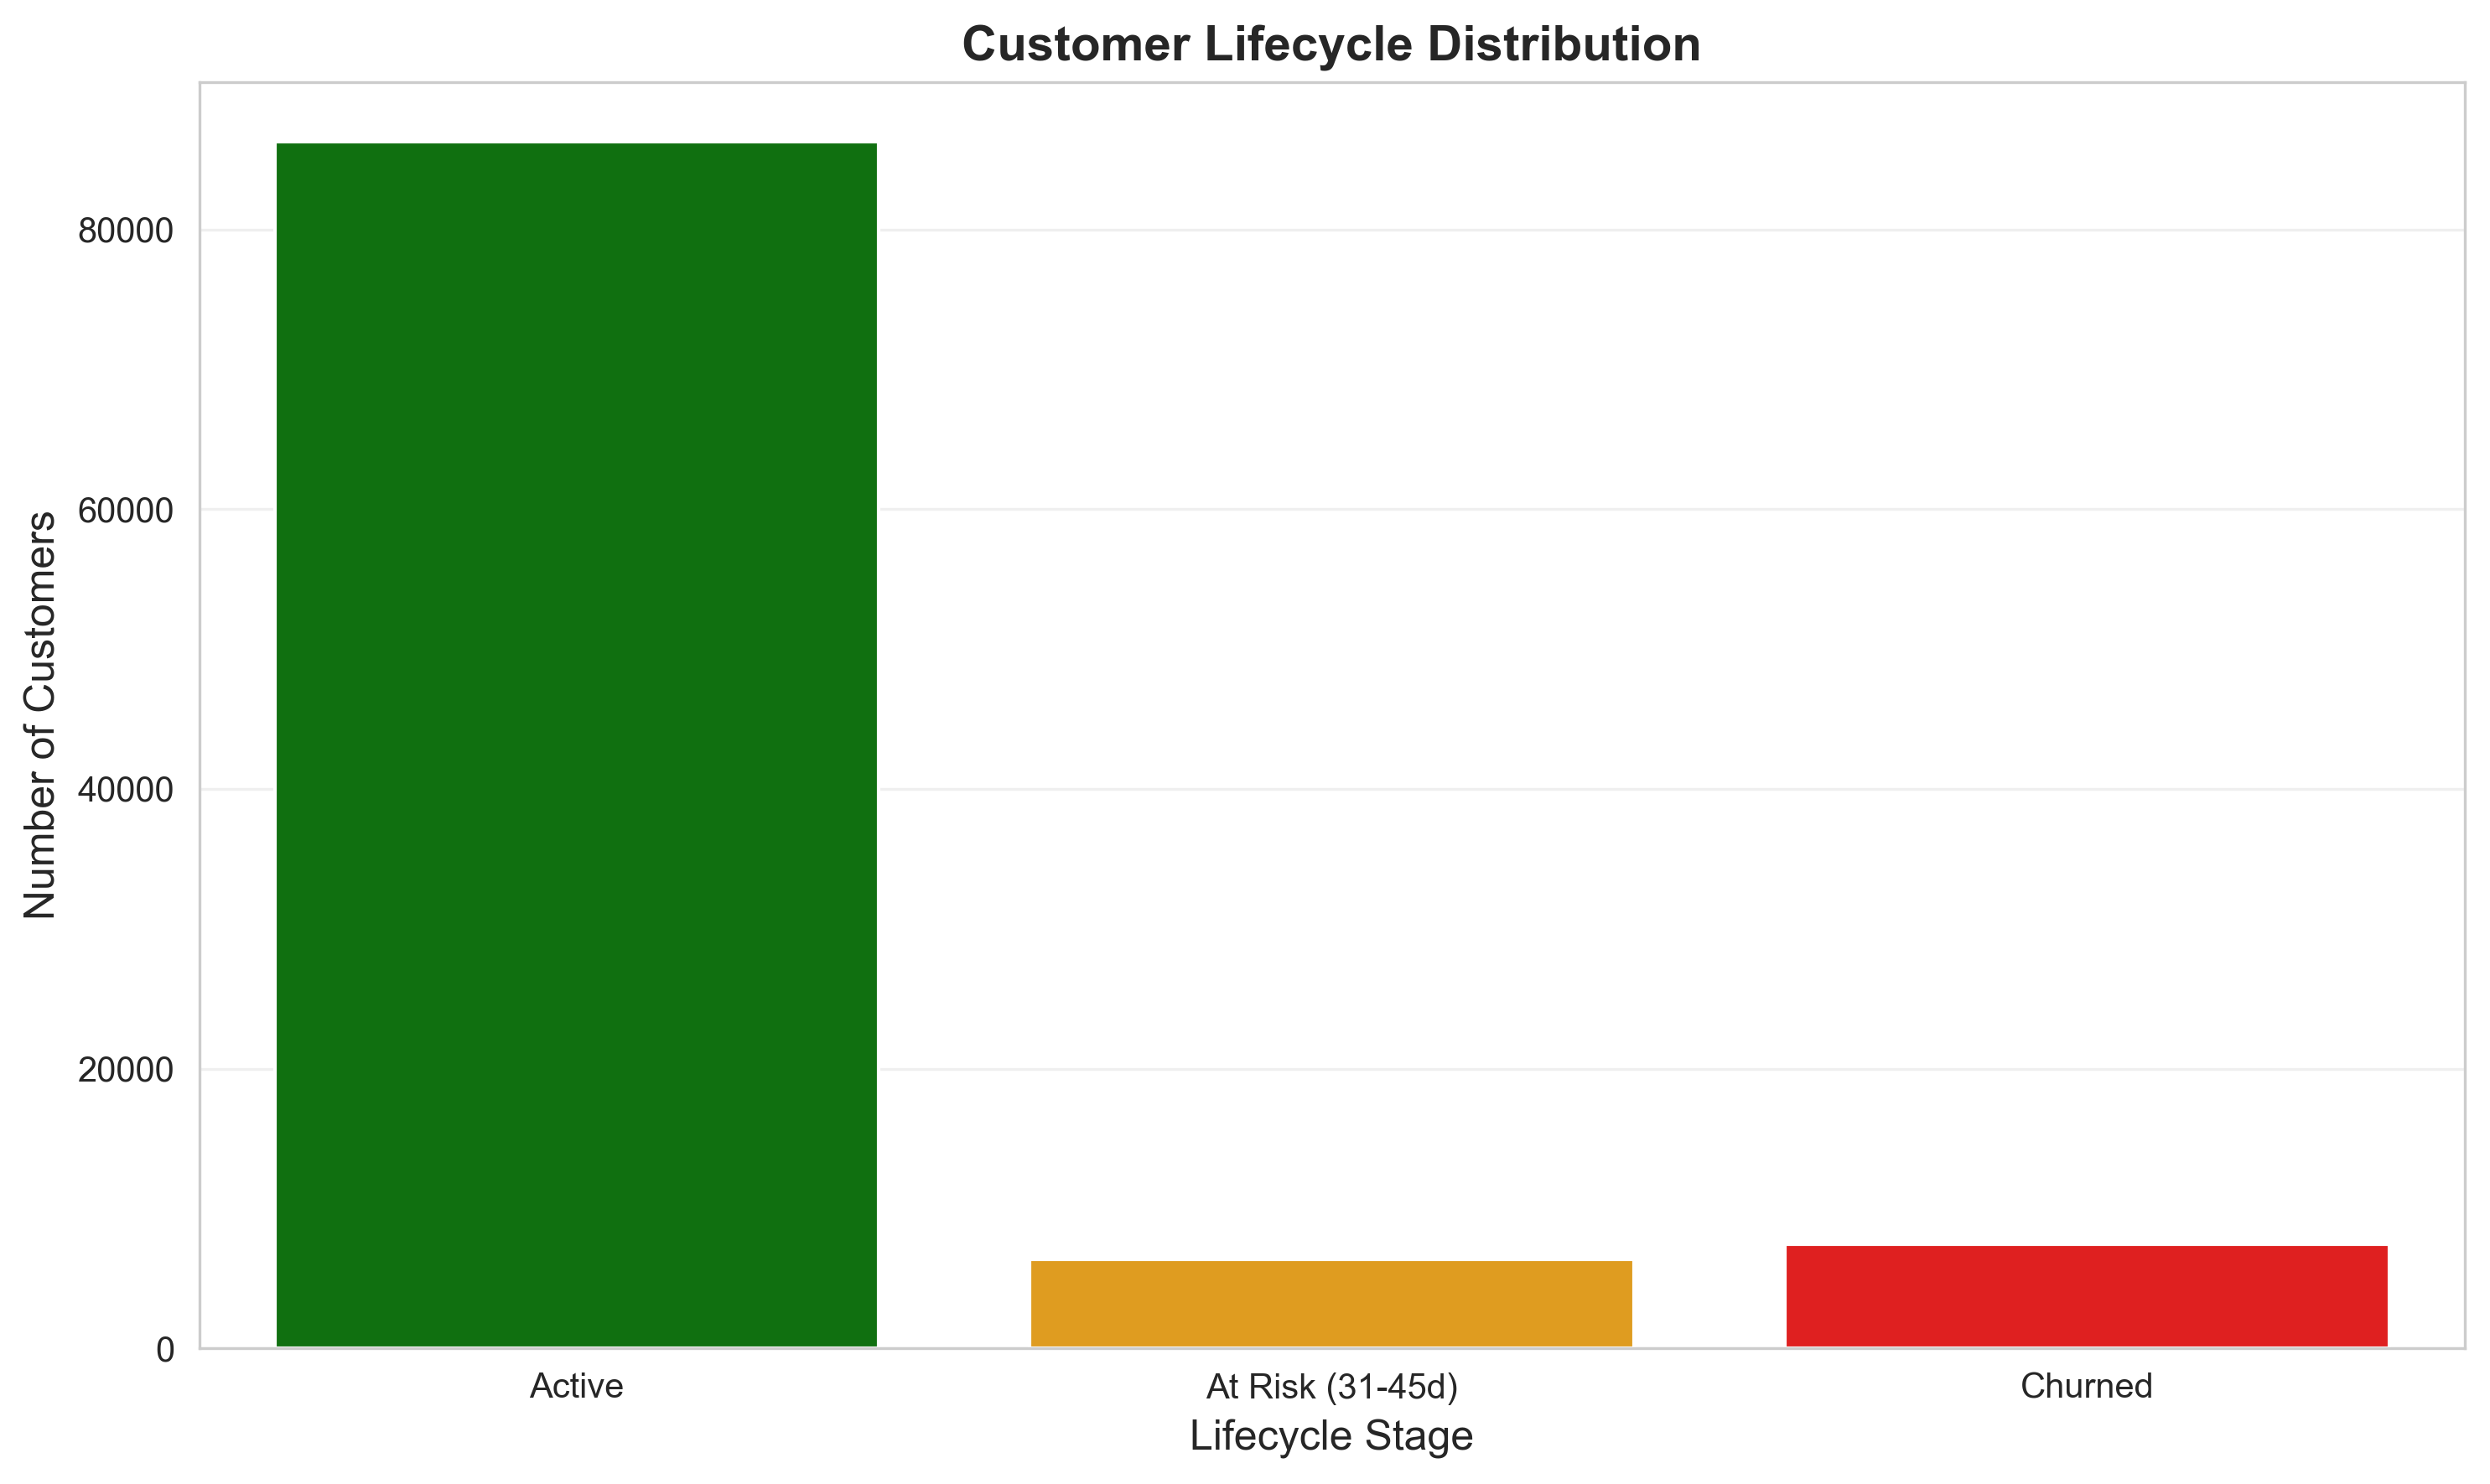

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(
    data=df_lifecycle,
    x='lifecycle_stage',
    hue='lifecycle_stage',
    order=lifecycle_order,
    palette={'Active': 'green', 'At Risk (31-45d)': 'orange', 'Churned': 'red'},
    legend=False
)
plt.title('Customer Lifecycle Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Lifecycle Stage', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Lifecycle by Plan

In [5]:
lifecycle_by_plan = df_lifecycle.groupby(['plan', 'lifecycle_stage']).size().reset_index(name='count')
lifecycle_by_plan_pivot = lifecycle_by_plan.pivot(index='plan', columns='lifecycle_stage', values='count').fillna(0)
lifecycle_by_plan_pivot = lifecycle_by_plan_pivot.reindex(columns=[s for s in lifecycle_order if s in lifecycle_by_plan_pivot.columns])

lifecycle_by_plan_pivot

lifecycle_stage,Active,At Risk (31-45d),Churned
plan,,,
Basic,31208,2031,1875
Enterprise,4918,93,45
Free,31346,3504,4995
Pro,18766,719,500


In [6]:
fig = px.bar(
    lifecycle_by_plan,
    x='plan',
    y='count',
    color='lifecycle_stage',
    color_discrete_map={'Active': 'green', 'At Risk (31-45d)': 'orange', 'Churned': 'red'},
    title='Customer Lifecycle by Plan',
    labels={'count': 'Number of Customers', 'plan': 'Plan'},
    barmode='stack'
)
fig.update_layout(
    height=500,
    xaxis={'categoryorder': 'total descending'}
)
fig.show()

## Recency Density by Lifecycle

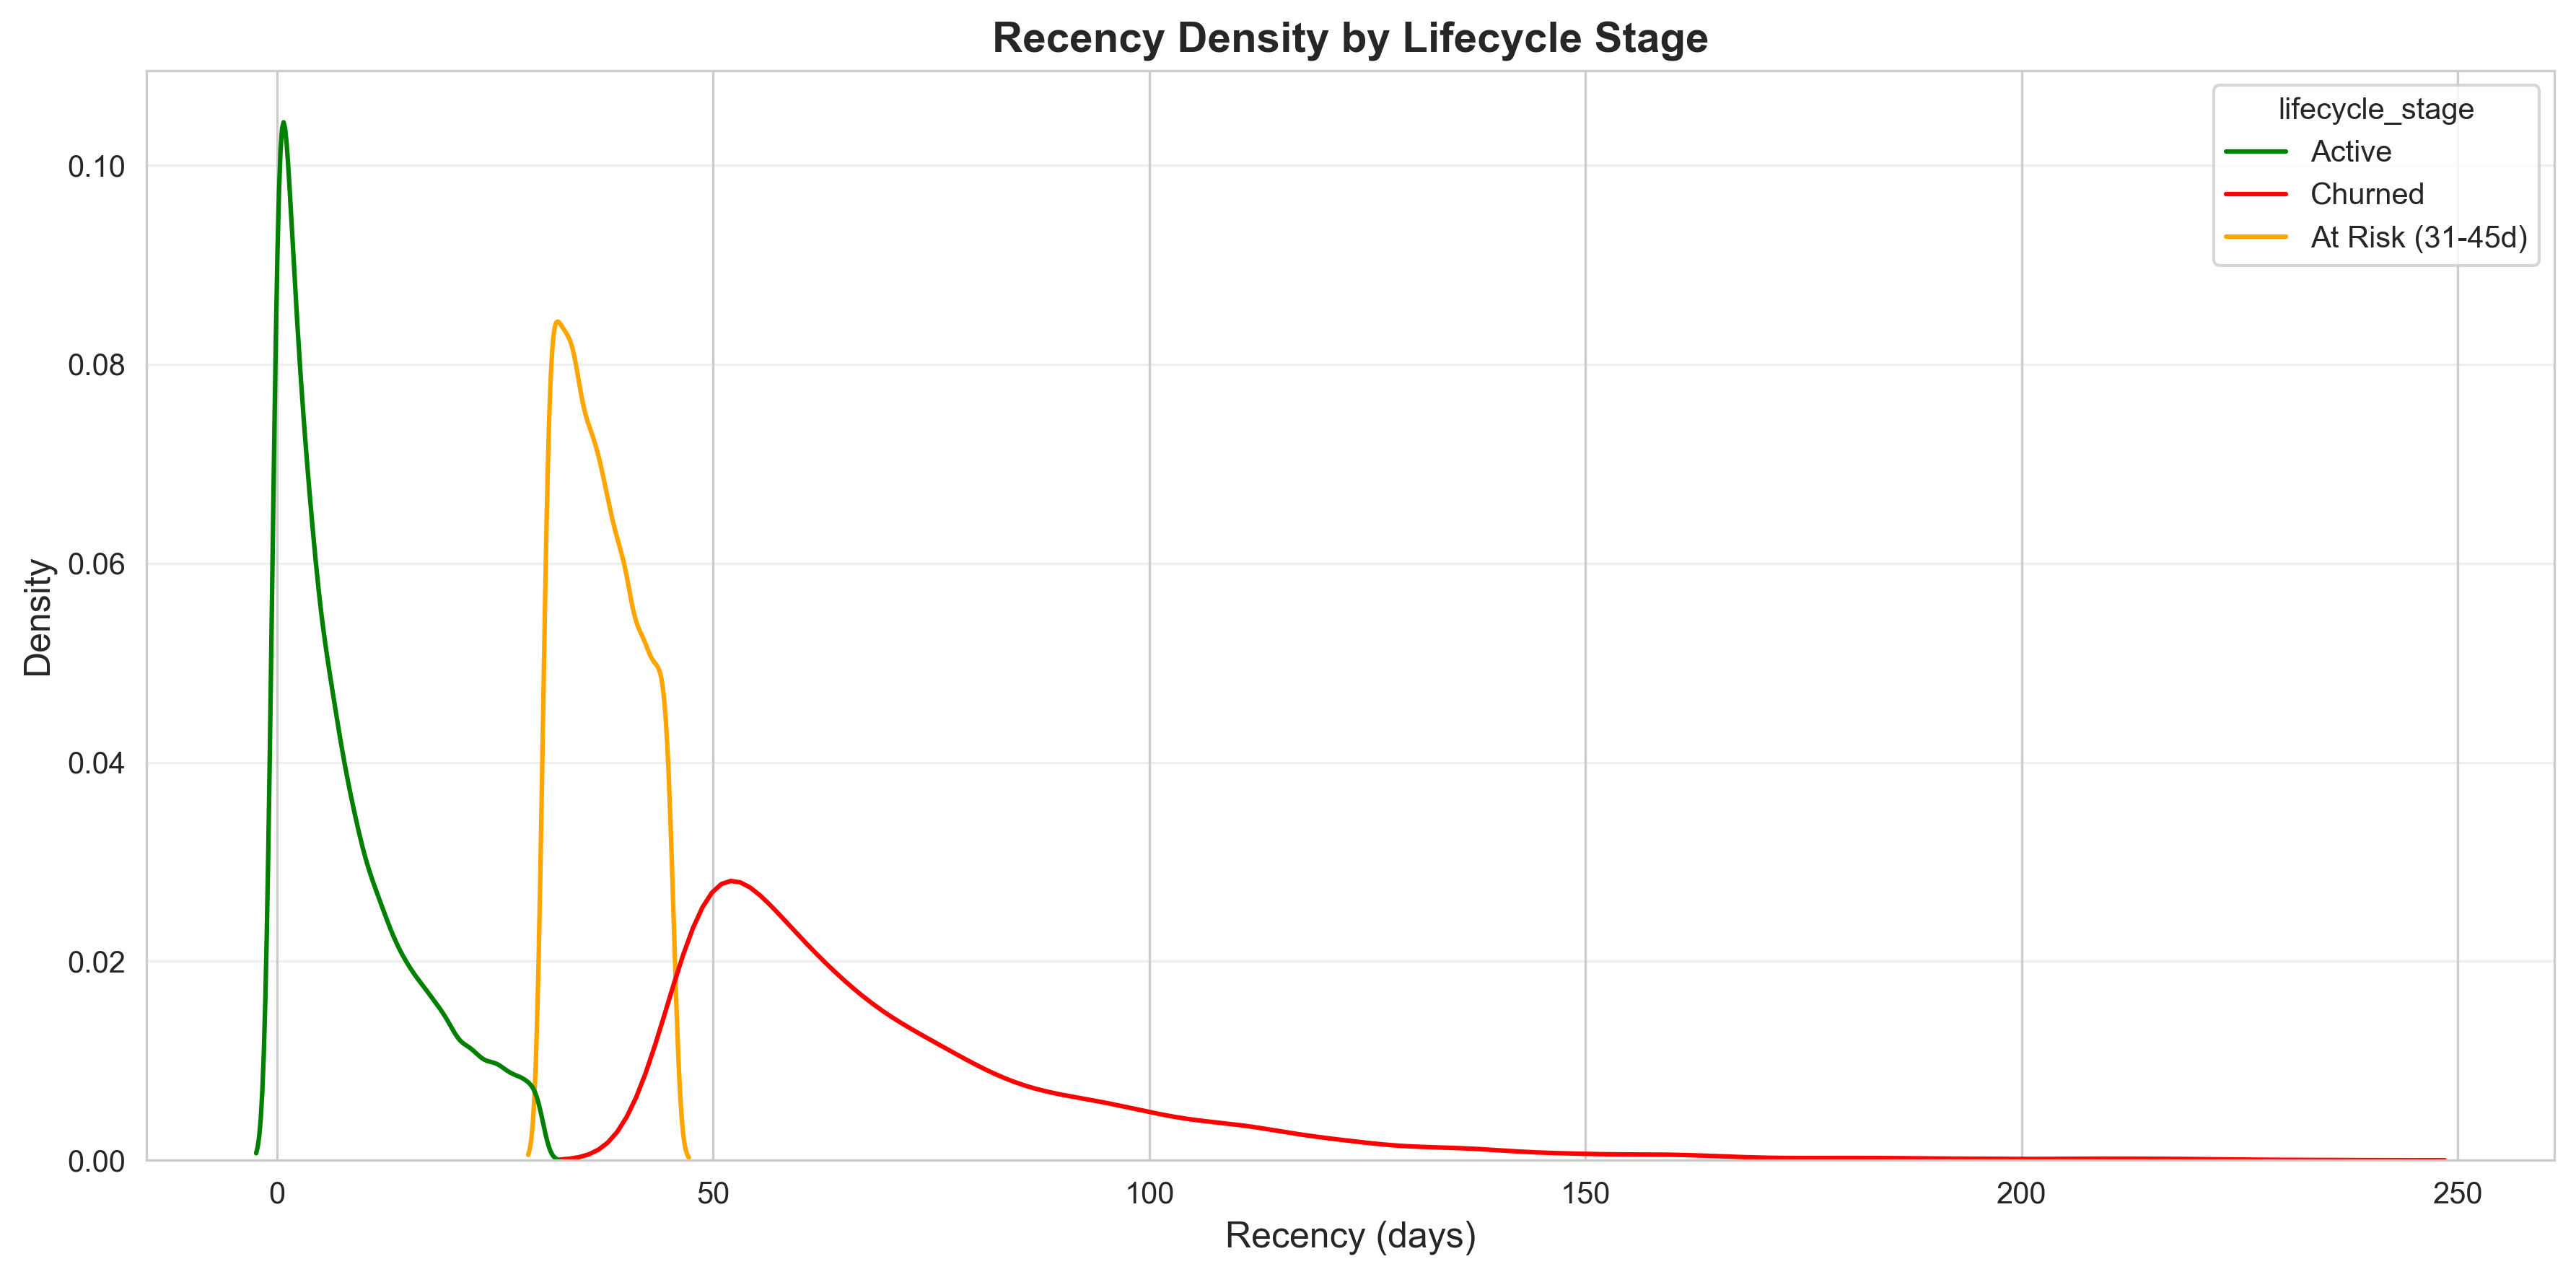

In [7]:
plt.figure(figsize=(12, 6))
df_lifecycle_recency = df_lifecycle[df_lifecycle['recency_days'].notna()].copy()
if len(df_lifecycle_recency) > 0:
    sns.kdeplot(
        data=df_lifecycle_recency,
        x='recency_days',
        hue='lifecycle_stage',
        common_norm=False,
        palette={'Active': 'green', 'At Risk (31-45d)': 'orange', 'Churned': 'red'}
    )
else:
    plt.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=plt.gca().transAxes)

plt.title('Recency Density by Lifecycle Stage', fontsize=14, fontweight='bold')
plt.xlabel('Recency (days)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Overview Statistics

In [8]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'customer_id']

df[numeric_cols].describe().round(2)

,active_days,avg_sessions,avg_usage_minutes,avg_usage_last_30d,avg_usage_prev_30d,usage_trend_30d,total_payment_issues,failed_payments_30d,zero_paid_anomalies,total_tickets,high_priority_tickets,recency_days
count,92610.0,92610.00,92610.00,85590.00,75580.00,72398.00,55679.00,55679.00,55679.0,80875.0,80875.00,92610.0
mean,40.72,12.03,89.35,93.36,96.06,-0.00,5.04,0.24,0.0,4.23,0.21,12.52
std,24.11,14.20,111.01,115.81,117.42,34.49,3.50,0.46,0.0,2.68,0.47,19.71
min,1.0,1.00,1.00,0.00,0.00,-546.33,0.00,0.00,0.0,1.0,0.00,0.0
25%,24.0,2.22,14.86,16.00,16.00,-7.58,2.00,0.00,0.0,2.0,0.00,2.0
50%,37.0,7.78,58.17,56.50,57.22,0.00,5.00,0.00,0.0,4.0,0.00,6.0
75%,55.0,23.77,165.82,145.25,152.89,7.62,7.00,0.00,0.0,6.0,0.00,14.0
max,147.0,65.73,679.33,814.00,814.00,552.00,20.00,3.00,0.0,19.0,4.00,235.0


In [9]:
print(f"Recency days: {df['recency_days'].median():.1f}")
print(f"Usage trend 30d: {df['usage_trend_30d'].median():.2f}")
print(f"Total payment issues: {df['total_payment_issues'].median():.0f}")
print(f"Total tickets: {df['total_tickets'].median():.0f}")

Recency days: 6.0
Usage trend 30d: 0.00
Total payment issues: 5
Total tickets: 4


## Churn by Plan

In [10]:
churn_by_plan = df.groupby('plan').agg({
    'churn_label': lambda x: ((x == 1).sum() / ((x == 1).sum() + (x == 0).sum()) * 100) if ((x == 1).sum() + (x == 0).sum()) > 0 else 0,
    'customer_id': 'count'
}).rename(columns={'churn_label': 'churn_rate', 'customer_id': 'total_customers'})
churn_by_plan = churn_by_plan.sort_values('churn_rate', ascending=False)

churn_by_plan

,churn_rate,total_customers
plan,,
Free,13.247720,35742
Basic,5.402190,32783
Pro,2.456360,19134
Enterprise,0.888709,4951


In [11]:
fig = px.bar(
    churn_by_plan.reset_index(),
    x='plan',
    y='churn_rate',
    title='Churn Rate by Plan',
    labels={'churn_rate': 'Churn Rate (%)', 'plan': 'Plan'},
    text='churn_rate',
    color='churn_rate',
    color_continuous_scale='Reds'
)
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    showlegend=False,
    height=500,
    xaxis={'categoryorder': 'total descending'}
)
fig.show()

## Churn by Region

In [12]:
churn_by_region = df.groupby('region').agg({
    'churn_label': lambda x: ((x == 1).sum() / ((x == 1).sum() + (x == 0).sum()) * 100) if ((x == 1).sum() + (x == 0).sum()) > 0 else 0,
    'customer_id': 'count'
}).rename(columns={'churn_label': 'churn_rate', 'customer_id': 'total_customers'})
churn_by_region = churn_by_region.sort_values('churn_rate', ascending=False)

churn_by_region

,churn_rate,total_customers
region,,
APAC,7.686329,23158
EU,7.684290,27823
NA,7.483182,32406
LATAM,7.340345,9223


In [13]:
fig = px.bar(
    churn_by_region.reset_index(),
    x='region',
    y='churn_rate',
    title='Churn Rate by Region',
    labels={'churn_rate': 'Churn Rate (%)', 'region': 'Region'},
    text='churn_rate',
    color='churn_rate',
    color_continuous_scale='Oranges'
)
fig.update_traces(texttemplate='%{text:.1f}%', textposition='outside')
fig.update_layout(
    showlegend=False,
    height=500,
    xaxis={'categoryorder': 'total descending'}
)
fig.show()

## Usage Trend Distribution

In [14]:
active_median = df[df['churn_label'] == 0]['usage_trend_30d'].median()
churned_median = df[df['churn_label'] == 1]['usage_trend_30d'].median()
print(f"Active median: {active_median:.2f}" if not pd.isna(active_median) else "Active median: N/A")
print(f"Churned median: {churned_median:.2f}" if not pd.isna(churned_median) else "Churned median: N/A")

Active median: 0.00
Churned median: N/A


w:\CodeBase\Resume-Projects\churn-retention-analytics\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1213: RuntimeWarning:

Mean of empty slice



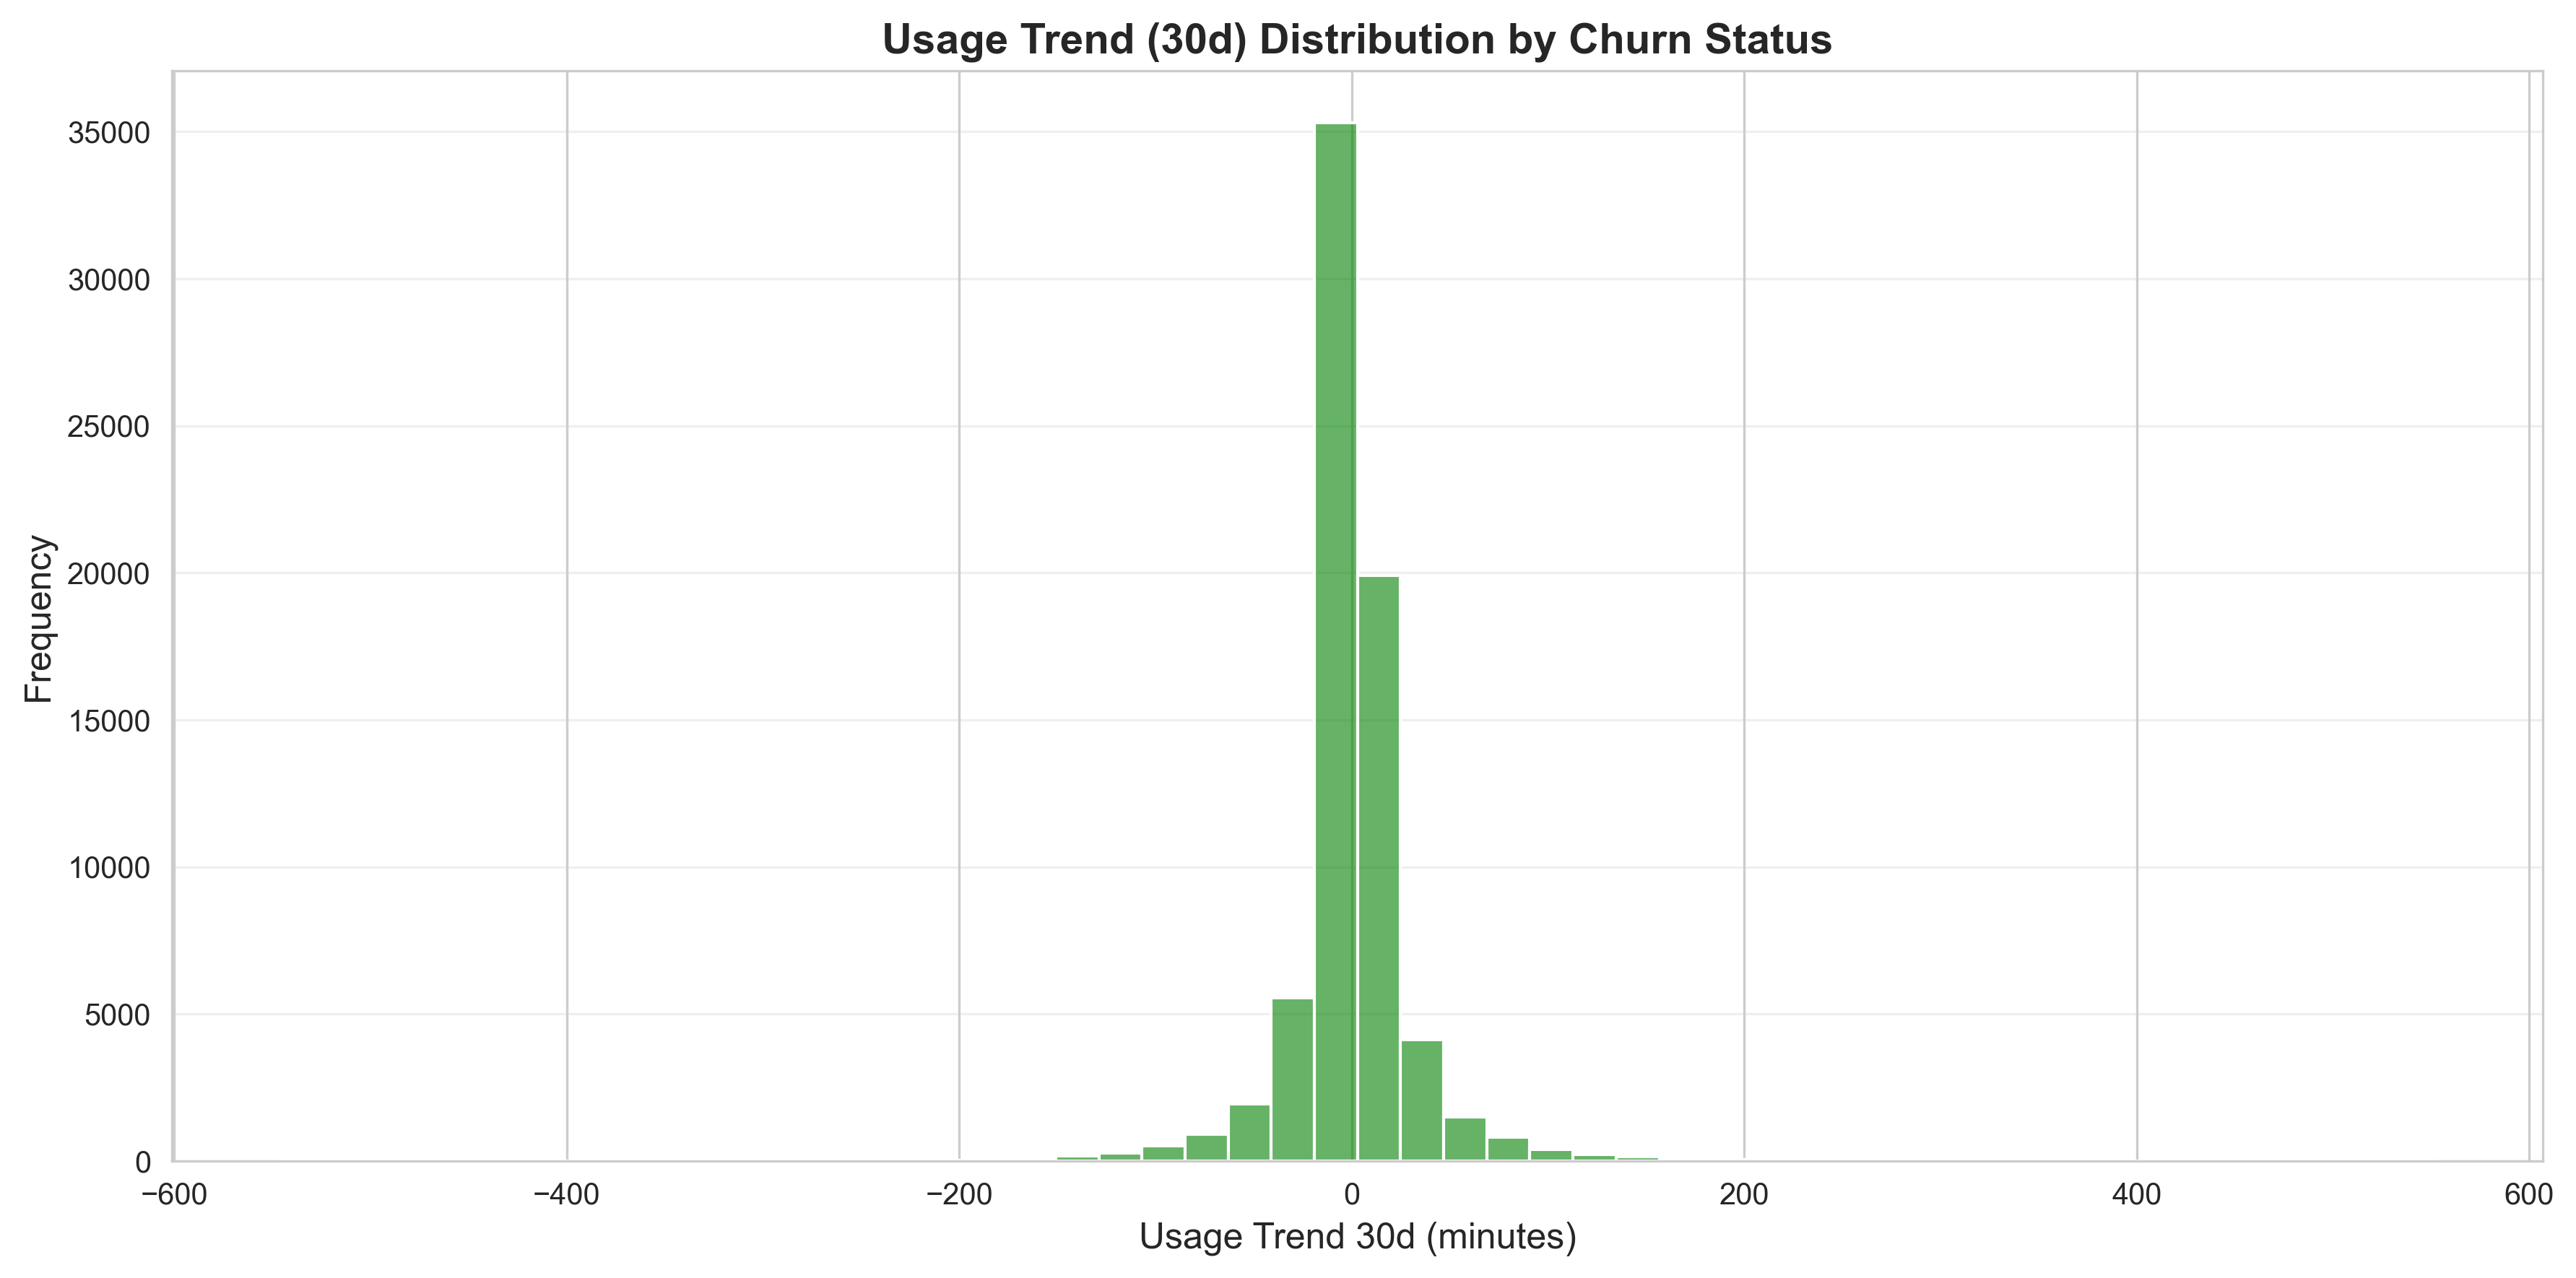

In [15]:
plt.figure(figsize=(12, 6))
df_usage = df[df['usage_trend_30d'].notna()].copy()
if len(df_usage) > 0:
    has_both_statuses = len(df_usage['churn_status'].unique()) > 1
    use_kde = len(df_usage) >= 100 and has_both_statuses
    
    if has_both_statuses:
        sns.histplot(
            data=df_usage,
            x='usage_trend_30d',
            hue='churn_status',
            bins=50,
            kde=use_kde,
            alpha=0.6,
            palette={'Active': 'green', 'Churned': 'red'}
        )
    else:
        sns.histplot(
            data=df_usage,
            x='usage_trend_30d',
            bins=50,
            kde=use_kde,
            alpha=0.6,
            color='red' if df_usage['churn_status'].iloc[0] == 'Churned' else 'green'
        )
else:
    plt.text(0.5, 0.5, 'No data available', ha='center', va='center', transform=plt.gca().transAxes)

plt.title('Usage Trend (30d) Distribution by Churn Status', fontsize=14, fontweight='bold')
plt.xlabel('Usage Trend 30d (minutes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
if len(df_usage) > 0 and len(df_usage['churn_status'].unique()) > 1:
    plt.legend(title='Churn Status')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Recency Distribution

In [16]:
active_recency = df[df['churn_label'] == 0]['recency_days'].median()
churned_recency = df[df['churn_label'] == 1]['recency_days'].median()
print(f"Active median recency: {active_recency:.1f} days" if not pd.isna(active_recency) else "Active median recency: N/A")
print(f"Churned median recency: {churned_recency:.1f} days" if not pd.isna(churned_recency) else "Churned median recency: N/A")

Active median recency: 5.0 days
Churned median recency: 63.0 days


C:\Users\Sumit\AppData\Local\Temp\ipykernel_16328\791485845.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




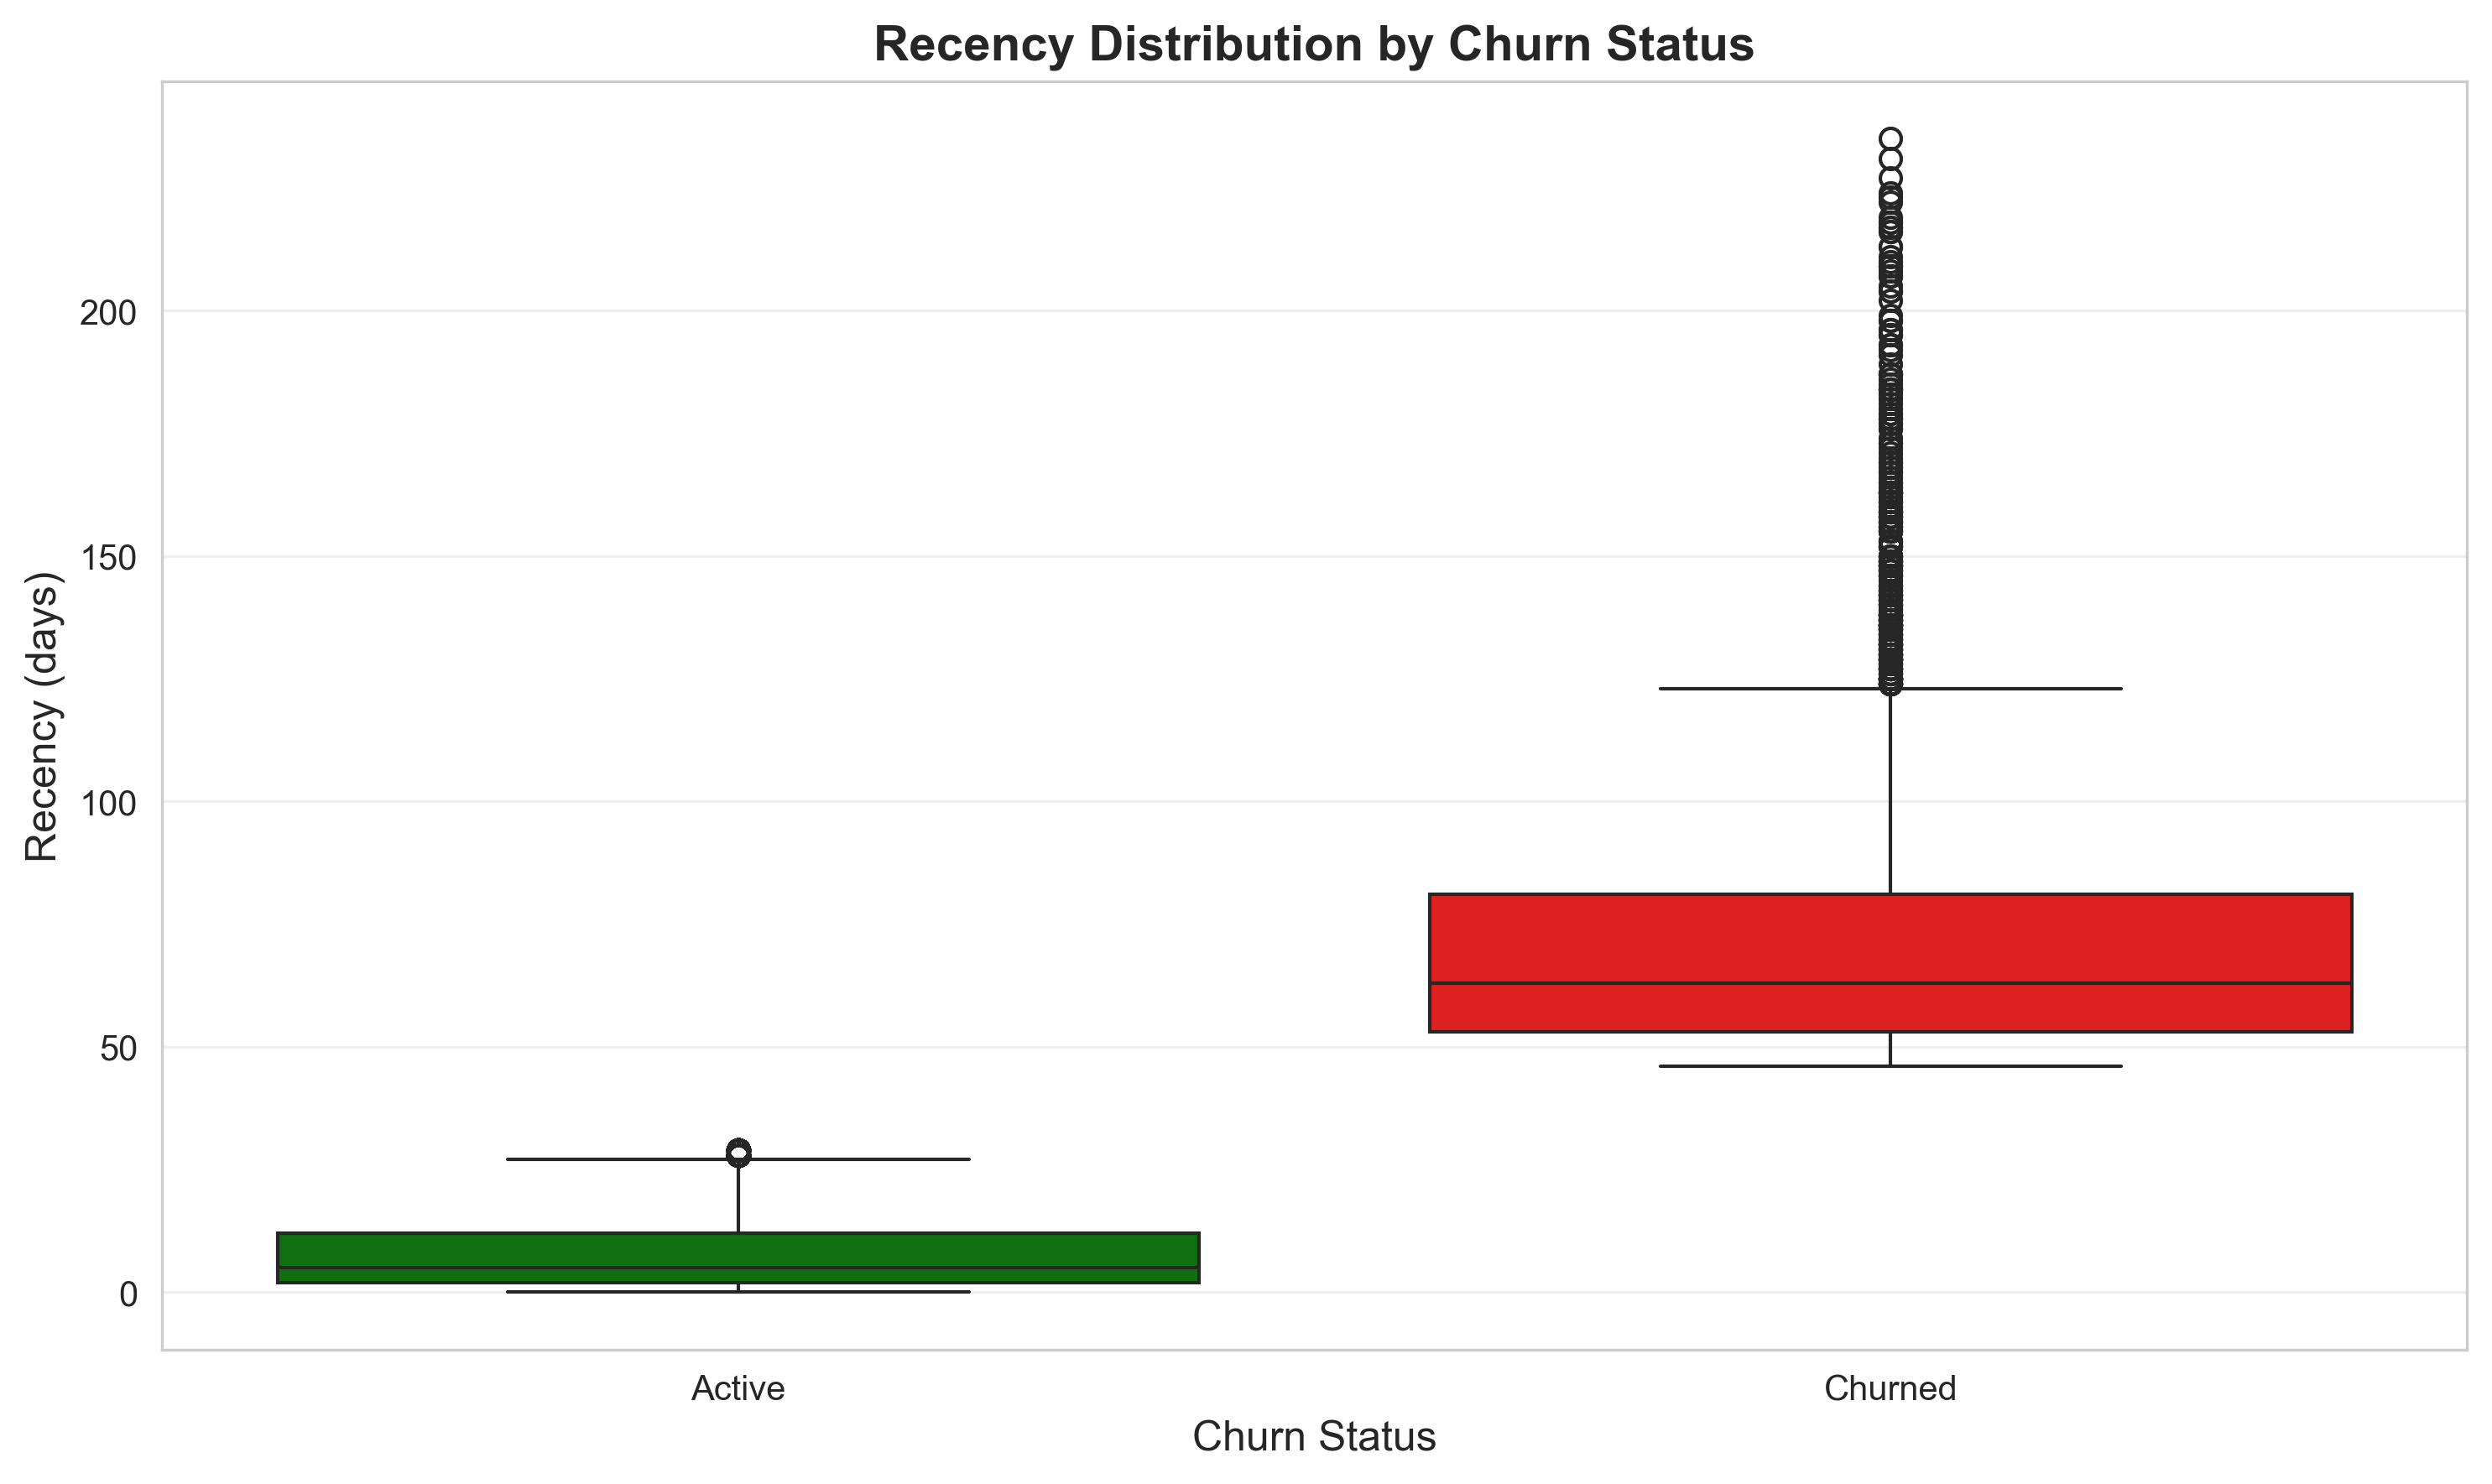

In [17]:
plt.figure(figsize=(10, 6))
has_both_statuses = len(df['churn_status'].unique()) > 1
if has_both_statuses:
    sns.boxplot(
        data=df,
        x='churn_status',
        y='recency_days',
        palette={'Active': 'green', 'Churned': 'red'}
    )
else:
    status = df['churn_status'].iloc[0]
    color = 'red' if status == 'Churned' else 'green'
    sns.boxplot(
        data=df,
        y='recency_days',
        color=color
    )
    plt.xlabel('Churn Status', fontsize=12)
    plt.xticks([0], [status])
plt.title('Recency Distribution by Churn Status', fontsize=14, fontweight='bold')
if has_both_statuses:
    plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Recency (days)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Retention Funnel

In [18]:
active_count = len(df_lifecycle[df_lifecycle['lifecycle_stage'] == 'Active'])
at_risk_count = len(df_lifecycle[df_lifecycle['lifecycle_stage'] == 'At Risk (31-45d)'])
churned_count = len(df_lifecycle[df_lifecycle['lifecycle_stage'] == 'Churned'])
total_customers = len(df_lifecycle)

funnel_data = pd.DataFrame({
    'Stage': ['Total Customers', 'Active (<=30 days)', 'At Risk (31-45 days)', 'Churned (>45 days)'],
    'Count': [total_customers, active_count, at_risk_count, churned_count]
})

funnel_data

,Stage,Count
0,Total Customers,100000
1,Active (<=30 days),86238
2,At Risk (31-45 days),6347
3,Churned (>45 days),7415


In [19]:
fig = go.Figure(go.Funnel(
    y=funnel_data['Stage'],
    x=funnel_data['Count'],
    textposition="inside",
    textinfo="value+percent initial",
    marker={"color": ["#1f77b4", "#2ca02c", "#ff7f0e", "#d62728"]}
))
fig.update_layout(
    title='Customer Retention Funnel',
    height=500
)
fig.show()

## Support Load Distribution

In [20]:
active_tickets_med = df[df['churn_label'] == 0]['total_tickets'].median()
churned_tickets_med = df[df['churn_label'] == 1]['total_tickets'].median()
print(f"Active median tickets: {active_tickets_med:.0f}" if not pd.isna(active_tickets_med) else "Active median tickets: N/A")
print(f"Churned median tickets: {churned_tickets_med:.0f}" if not pd.isna(churned_tickets_med) else "Churned median tickets: N/A")

Active median tickets: 4
Churned median tickets: 6


C:\Users\Sumit\AppData\Local\Temp\ipykernel_16328\1599628968.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




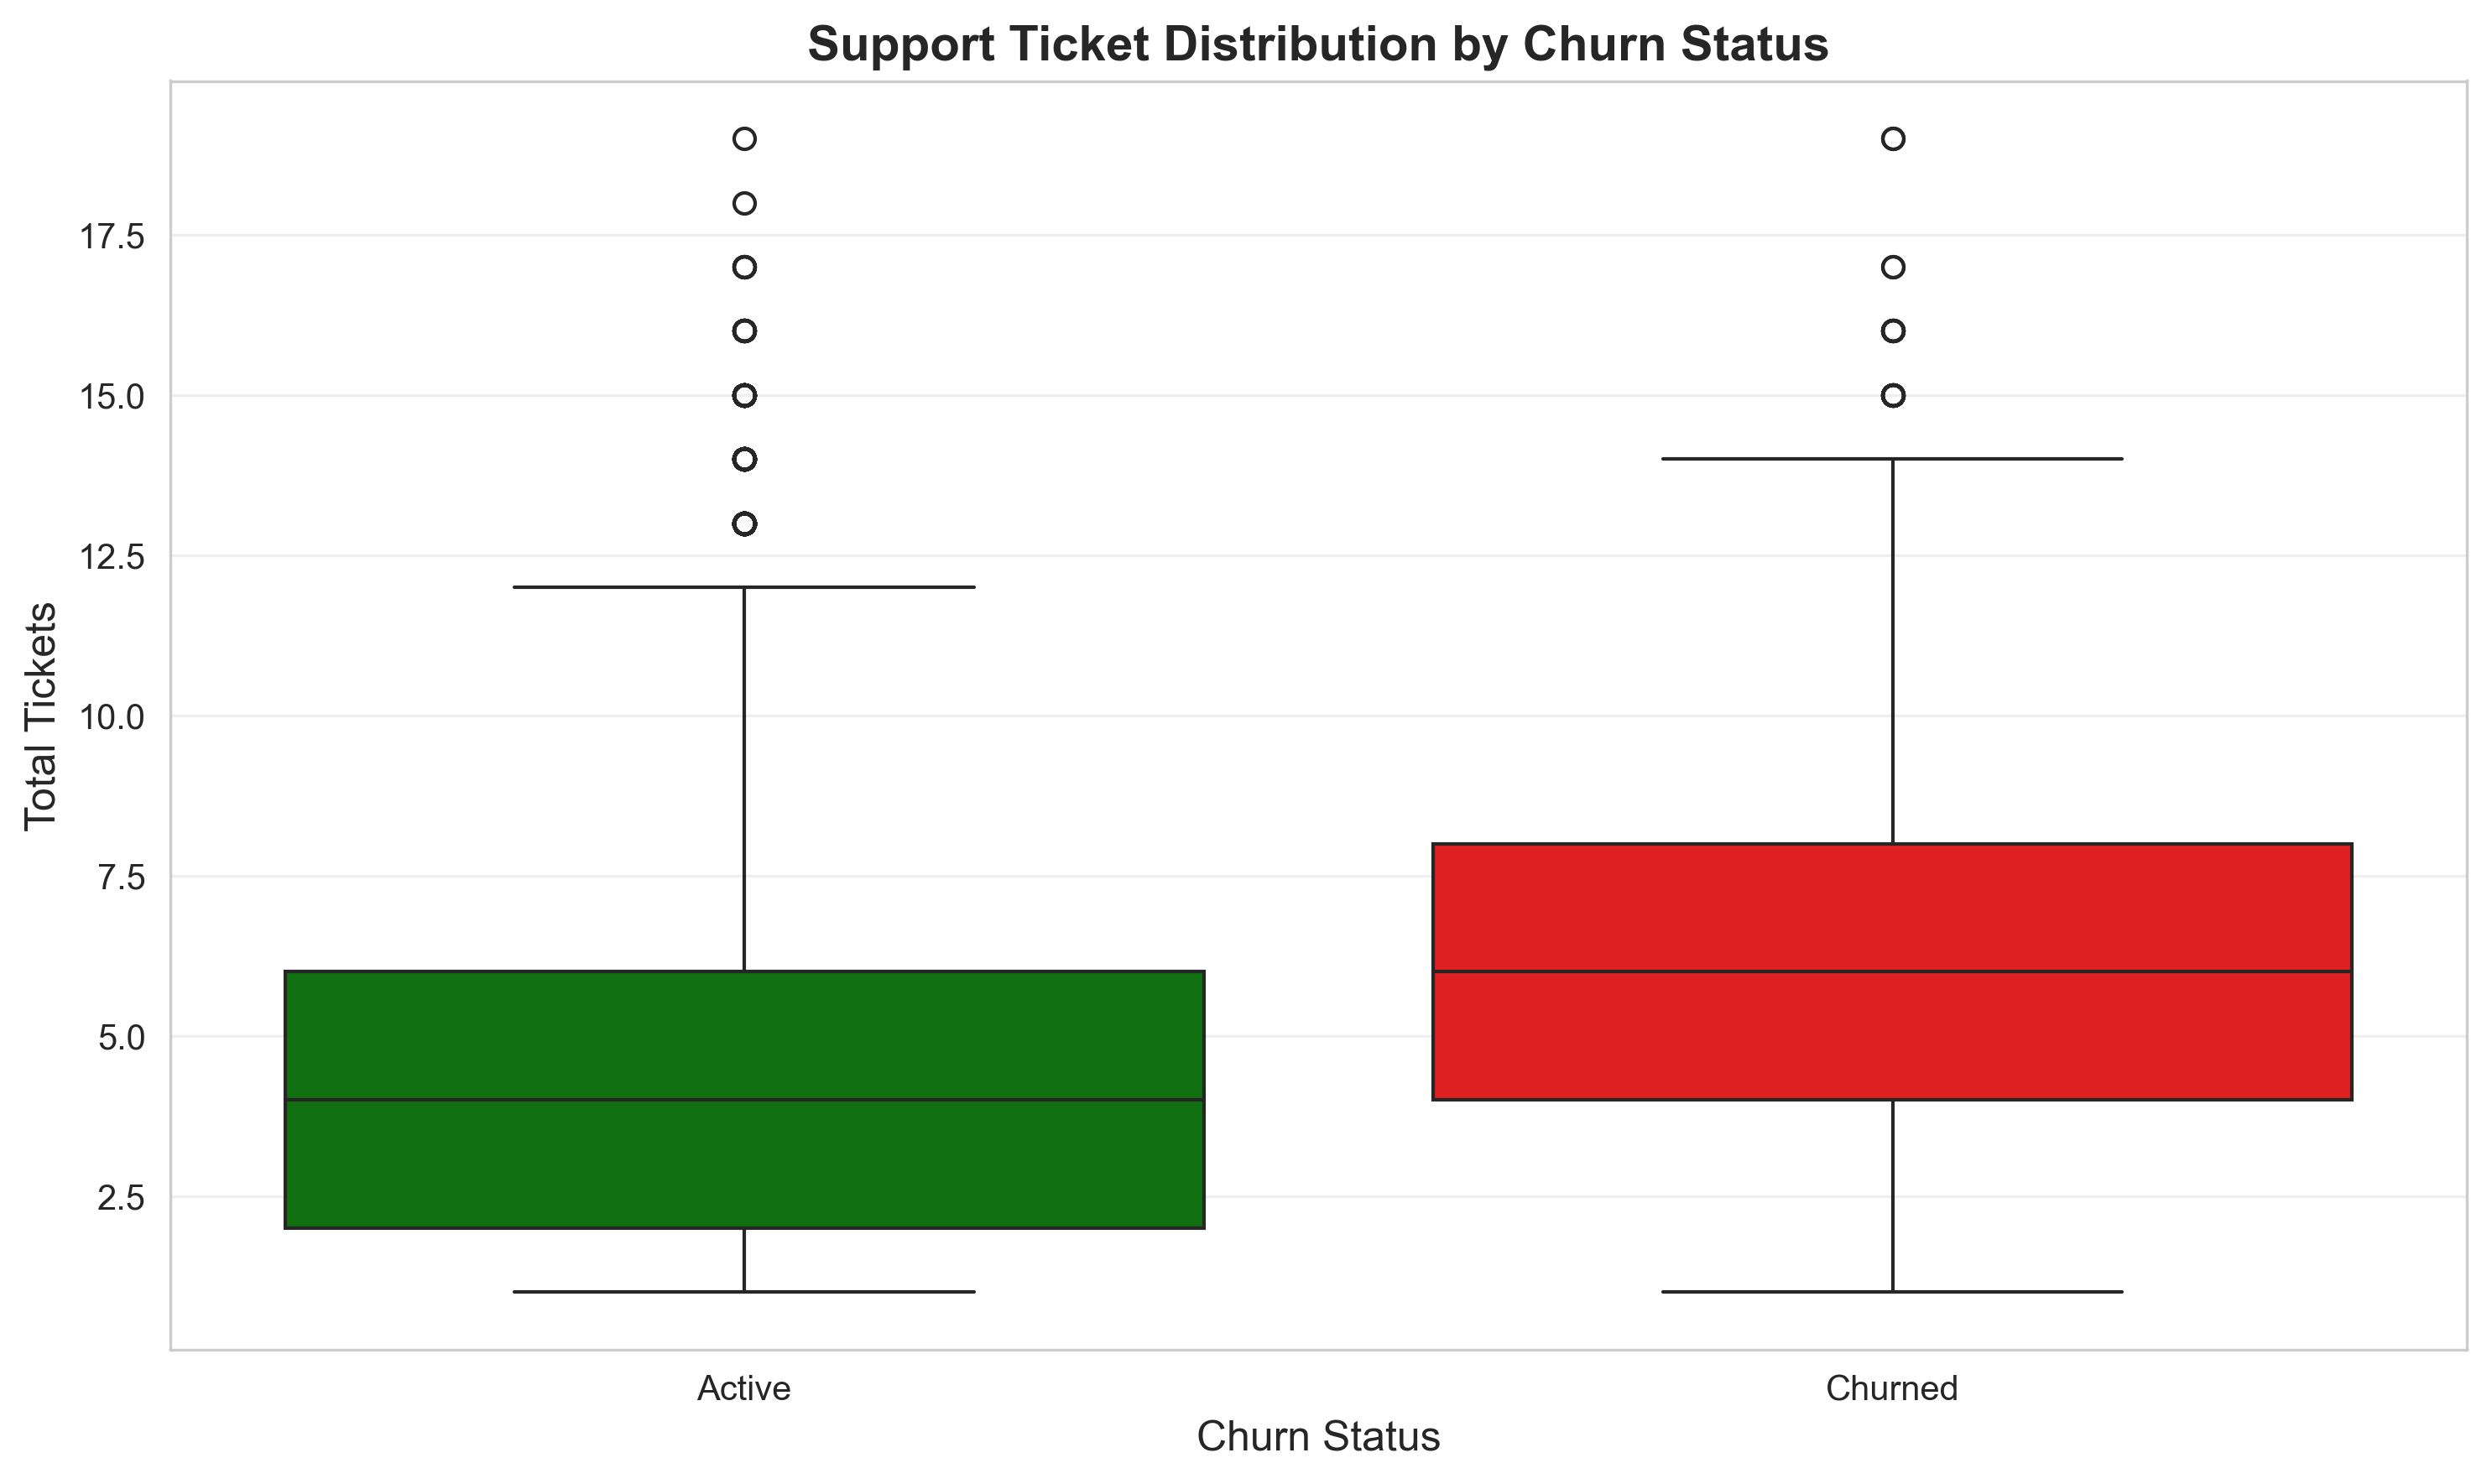

In [21]:
plt.figure(figsize=(10, 6))
has_both_statuses = len(df['churn_status'].unique()) > 1
if has_both_statuses:
    sns.boxplot(
        data=df,
        x='churn_status',
        y='total_tickets',
        palette={'Active': 'green', 'Churned': 'red'}
    )
else:
    status = df['churn_status'].iloc[0]
    color = 'red' if status == 'Churned' else 'green'
    sns.boxplot(
        data=df,
        y='total_tickets',
        color=color
    )
    plt.xticks([0], [status])
plt.title('Support Ticket Distribution by Churn Status', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Total Tickets', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Key Insights

In [22]:
insights = []

highest_plan_churn = churn_by_plan.index[0]
highest_plan_rate = churn_by_plan.loc[highest_plan_churn, 'churn_rate']
lowest_plan_churn = churn_by_plan.index[-1]
lowest_plan_rate = churn_by_plan.loc[lowest_plan_churn, 'churn_rate']
insights.append(f"Plan '{highest_plan_churn}' has highest churn rate ({highest_plan_rate:.1f}%), '{lowest_plan_churn}' has lowest ({lowest_plan_rate:.1f}%)")

highest_region_churn = churn_by_region.index[0]
highest_region_rate = churn_by_region.loc[highest_region_churn, 'churn_rate']
insights.append(f"Region '{highest_region_churn}' shows highest churn rate ({highest_region_rate:.1f}%)")

at_risk_pct = (at_risk_count / total_customers) * 100
insights.append(f"{at_risk_pct:.1f}% of customers are in At Risk (31-45d) stage, representing a key intervention opportunity")

at_risk_by_plan = df_lifecycle[df_lifecycle['lifecycle_stage'] == 'At Risk (31-45d)'].groupby('plan').size()
if len(at_risk_by_plan) > 0:
    highest_at_risk_plan = at_risk_by_plan.idxmax()
    highest_at_risk_count = at_risk_by_plan.max()
    plan_total = df_lifecycle[df_lifecycle['plan'] == highest_at_risk_plan].shape[0]
    highest_at_risk_pct = (highest_at_risk_count / plan_total) * 100 if plan_total > 0 else 0
    insights.append(f"Plan '{highest_at_risk_plan}' has the highest concentration of At Risk customers ({highest_at_risk_pct:.1f}% of plan customers)")

active_trend = df[df['churn_label'] == 0]['usage_trend_30d'].median()
churned_trend = df[df['churn_label'] == 1]['usage_trend_30d'].median()
insights.append(f"Churned customers show {churned_trend:.2f} min/day usage trend vs {active_trend:.2f} for active (median)")

active_tickets = df[df['churn_label'] == 0]['total_tickets'].median()
churned_tickets = df[df['churn_label'] == 1]['total_tickets'].median()
insights.append(f"Churned customers have median {churned_tickets:.0f} support tickets vs {active_tickets:.0f} for active")

insights.append(f"Overall churn rate: {churn_rate:.2f}% ({churned.sum():,} churned / {active.sum():,} active)")

high_recency = df[df['churn_label'] == 1]['recency_days'].median()
low_recency = df[df['churn_label'] == 0]['recency_days'].median()
insights.append(f"Churned customers have median recency of {high_recency:.0f} days vs {low_recency:.0f} days for active")

for insight in insights:
    print(insight)

Plan 'Free' has highest churn rate (13.2%), 'Enterprise' has lowest (0.9%)
Region 'APAC' shows highest churn rate (7.7%)
6.3% of customers are in At Risk (31-45d) stage, representing a key intervention opportunity
Plan 'Free' has the highest concentration of At Risk customers (8.8% of plan customers)
Churned customers show nan min/day usage trend vs 0.00 for active (median)
Churned customers have median 6 support tickets vs 4 for active
Overall churn rate: 7.58% (7,020 churned / 85,590 active)
Churned customers have median recency of 63 days vs 5 days for active


w:\CodeBase\Resume-Projects\churn-retention-analytics\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1213: RuntimeWarning:

Mean of empty slice

